In [1]:
import re
import pandas as pd
import spacy
from typing import List
from math import sqrt, ceil
# gensim
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
# plotting
from matplotlib import pyplot as plt
from wordcloud import WordCloud
import matplotlib.colors as mcolors
# progress bars
from tqdm.notebook import tqdm
tqdm.pandas()

unable to import 'smart_open.gcs', disabling that module


### Params

In [2]:
params = dict(
    num_topics = 15,
    iterations = 200,
    epochs = 20,
    minDF = 0.02,
    maxDF = 0.8,
)

#### Files
Input CSV file and stopword files.

In [3]:
inputfile = "../../data/nytimes.tsv"
stopwordfile = "../stopwords/custom_stopwords.txt"

def get_stopwords():
    # Read in stopwords
    with open(stopwordfile) as f:
        stopwords = []
        for line in f:
            stopwords.append(line.strip("\n"))
    return stopwords

stopwords = get_stopwords()

### Read in New York Times Dataset
A pre-processed version of the NYT news dataset is read in as a DataFrame.

In [4]:
def read_data(inputfile):
    "Read in a tab-separated file with date, headline and news content"
    df = pd.read_csv(inputfile, sep='\t', header=None,
                     names=['date', 'headline', 'content'])
    df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
    return df

In [5]:
df = read_data(inputfile)
df.head()

,date,headline,content
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...
3,2016-06-30,tekserve precursor to the apple store to close...,It was the Apple Store in New York City before...
4,2016-06-30,once at michael phelpss feet and still chasing...,The United States Olympic swimming trials are ...


### Clean the input text
We clean the text from each article's content to only contain relevant alphanumeric strings (symbols do not add any value to topic modelling).

In [6]:
def clean_data(df):
    "Extract relevant text from DataFrame using a regex"
    # Regex pattern for only alphanumeric, hyphenated text with 3 or more chars
    pattern = re.compile(r"[A-Za-z0-9\-]{3,50}")
    df['clean'] = df['content'].str.findall(pattern).str.join(' ')
    return df

In [7]:
df_clean = clean_data(df)

#### (Optional) Subset the dataframe for testing
Test on a subset of the full data for quicker results.

In [8]:
df1 = df_clean.iloc[:2000, :].copy()
# df1 = df_clean.copy()

### Preprocess text for topic modelling

In [9]:
def lemmatize(text, nlp):
    "Perform lemmatization and stopword removal in the clean text"
    doc = nlp(text)
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.is_alpha and tok.text.lower() not in stopwords]
    return lemma_list

def preprocess(df):
    "Preprocess text in each row of the DataFrame"
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    nlp.add_pipe(nlp.create_pipe('sentencizer'))
    df['lemmas'] = df['clean'].progress_apply(lambda row: lemmatize(row, nlp))
    return df.drop('clean', axis=1)

In [10]:
df_preproc = preprocess(df1)
df_preproc.head(3)

,date,headline,content,lemmas
0,2016-06-30,washington nationals max scherzer baffles mets...,Stellar pitching kept the Mets afloat in the f...,"[stellar, pitching, keep, mets, afloat, half, ..."
1,2016-06-30,mayor de blasios counsel to leave next month t...,Mayor Bill de Blasio’s counsel and chief legal...,"[mayor, bill, blasio, counsel, chief, legal, a..."
2,2016-06-30,three men charged in killing of cuomo administ...,In the early morning hours of Labor Day last y...,"[early, hour, labor, group, gunman, street, ga..."


### Build LDA Topic Model

#### Multicore LDA algorithm

In [11]:
# Choose number of workers for multicore LDA as (num_physical_cores - 1)
def run_lda_multicore(text_df, params, workers=7):
    id2word = corpora.Dictionary(text_df['lemmas'])
    # Filter out words that occur in less than 2% documents or more than 50% of the documents.
    id2word.filter_extremes(no_below=params['minDF'], no_above=params['maxDF'])
    corpus = [id2word.doc2bow(text) for text in text_df['lemmas']]
    # LDA Model
    lda_model = LdaMulticore(
        corpus=corpus,
        id2word=id2word,
        workers=workers,
        num_topics=params['num_topics'],
        random_state=1,
        chunksize=2048,
        passes=params['epochs'],
        iterations=params['iterations'],
    )
    return lda_model, corpus

### Wordclouds of most likely words in each topic

In [12]:
def plot_wordclouds(topics, colormap="cividis"):
    cloud = WordCloud(
        background_color='white',
        width=600,
        height=400,
        colormap=colormap,
        prefer_horizontal=1.0,
    )

    num_topics = len(topics)
    fig_width = min(ceil(0.6 * num_topics + 6), 20)
    fig_height = min(ceil(0.65 * num_topics), 20)
    fig = plt.figure(figsize=(fig_width, fig_height))

    for idx, word_weights in tqdm(enumerate(topics), total=num_topics):
        ax = fig.add_subplot((num_topics / 5) + 1, 5, idx + 1)
        wordcloud = cloud.generate_from_frequencies(word_weights)
        ax.imshow(wordcloud, interpolation="bilinear")
        ax.set_title('Topic {}'.format(idx + 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.tick_params(length=0)

    plt.tick_params(labelsize=14)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.margins(x=0.1, y=0.1)
    st = fig.suptitle("LDA Topics", y=0.92)
    fig.savefig("pyspark-topics.png", bbox_extra_artists=[st], bbox_inches='tight')

### Run topic model and plot wordclouds

In [13]:
model, corpus = run_lda_multicore(df_preproc, params)

#### Convert topic words to a list of dicts

In [14]:
topic_list = model.show_topics(formatted=False,
                               num_topics=params['num_topics'],
                               num_words=15)
topics = [dict(item[1]) for item in topic_list]

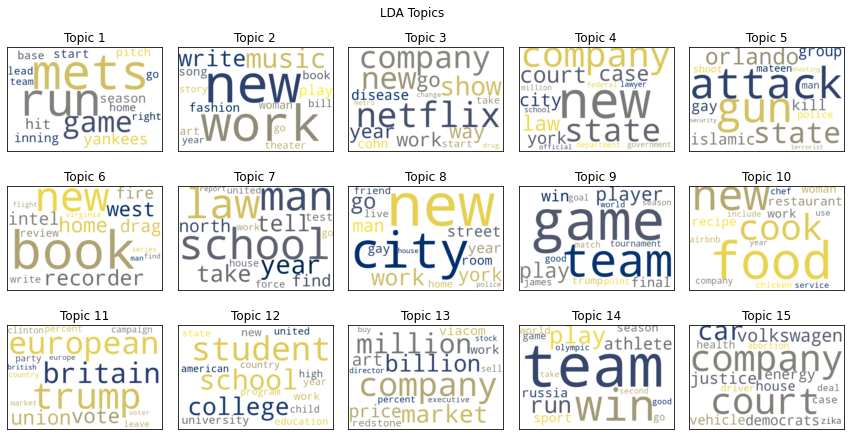

In [15]:
plot_wordclouds(topics)